# Slightly modified version of Miles' code for the initial crop of our image + 

In [ ]:
#The following code snip-it reads any file from the internet and saves it to your local directory.
from urllib.request import urlopen, urlretrieve
from imageio import imread, imsave
from matplotlib.pylab import plt
import numpy as np
import skimage
from skimage.morphology import remove_small_holes
from skimage.morphology import remove_small_objects
from skimage import exposure #histogram equalization
import colorsys #To convert to rbg to hsv color space
import matplotlib.colors as colors
import os #For getting list of files
from scipy import ndimage #For performing erosion and dilation
from ipywidgets import interactive,fixed #For interactives

#Get list of photo names
fileNames = ['IMG_8277.jpg','IMG_8280.jpg','IMG_8333.jpg','IMG_8338.jpg','IMG_8342.jpg','IMG_8343.jpg','IMG_8312.jpg','IMG_8284.jpg','IMG_8349.jpg']

#Define thresholds for isolating tray in photos
hmin = -0.01
hmax = 1.01
smin = -0.01
smax = 0.05
vmin = -0.01
vmax = 1.01

#Function for calculating run lengths in a binary array
#function is from: https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

conversion_dict = {}        

#Loop over photos and crop them
for fileName in fileNames:
    #Load picture
    im = imread(fileName)
    
    #Histogram equalization
    im2 = exposure.equalize_hist(im)
    
    #convert from rgb to hsv color space, pull out matrices
    hsv = colors.rgb_to_hsv(im2)
    h = hsv[:,:,0]; #hue matrix
    s = hsv[:,:,1]; #saturation matrix
    v = hsv[:,:,2]; #value matrix (i.e. brightness)
    
    #Convert to binary image based on thresholds
    # trick because the color space wraps
    if hmin > hmax:
        b_img = (h > hmin) | (h < hmax)
    else:
        b_img = (h > hmin) & (h < hmax);
    b_img = (b_img & 
        (s > smin) & (s < smax) & 
        (v > vmin) & (v < vmax));
    
    #Clean up binary image with erosion and dilation
    b4 = skimage.morphology.remove_small_holes(b_img,area_threshold=50000) # removing holes
    b5 = skimage.morphology.remove_small_holes(b4,area_threshold=10000) # removing holes again
    b6 = skimage.morphology.remove_small_holes(b5,area_threshold=10000) # removing even more holes
    b8 = remove_small_objects(b6,min_size=50000) #removing any chaff 
    
    #Label objects in binary image
    lab, num_features = ndimage.measurements.label(b8)
    
    #Sum togther rows and columns of binary array to determine which pixels represent the tray (labeled as object 1) 
    a1 = np.sum(lab==1,axis=1)
    a0 = np.sum(lab==1,axis=0)
    
    #Convert binary arrays to logical arrays. Now just need to find longest run of False elements in each array
    al0 = a0 > min(a0)
    al1 = a1 > min(a1)
    
    #Calculate run lengths
    runLengths0 = rle(al0)
    runLengths1 = rle(al1)
    
    #Focus on columns
    ##Find index of where longest run begins
    runs0 = runLengths0[0]
    positions0 =  runLengths0[1]
    maxRun0 = max(runs0)
    result = np.where(runs0 == maxRun0)
    ##Calculate where longest run ends
    index = np.asarray(result)
    startCol = positions0[index].tolist()[0][0] - 120
    endCol = startCol + maxRun0 + 240
    
    #Focus on rows
    ##Find index of where longest run begins
    runs1 = runLengths1[0]
    positions1 =  runLengths1[1]
    maxRun1 = max(runs1)
    result = np.where(runs1 == maxRun1)
    ##Calculate where longest run ends
    index = np.asarray(result)
    startRow = positions1[index].tolist()[0][0] - 120
    endRow = startRow + maxRun1 + 240
    
    # calculate conversion factor by relating run lengths identified above (maxRun0 is columns and maxRun1 is rows)
    # and updating a dictionary, called conversion_dict, with a fileName to conversion factor key:value relationship.
    # Note that we don't want to overwrite our files, so we create a 'finalFilename' ahead of time, use that to
    # create the dictionary, and then use it to also export our new images. Additionally, we take the average of the
    # pixel-to-cm relationships for extra robustness
    
    finalFilename = "testing_" + fileName
    
    top_bottom_in_cm = 38.5
    left_right_in_cm = 29.4
    conversion_top_bottom = top_bottom_in_cm / maxRun0
    conversion_left_right = left_right_in_cm / maxRun1
    average_conversion = (conversion_top_bottom + conversion_left_right) / 2
    new_addition = {finalFilename:average_conversion}
    conversion_dict.update(new_addition)
    
    #Crop and save image
    im3 = im2[startRow:endRow,startCol:endCol]
    imsave(finalFilename, im3)

# JK Ear Crop Function - MDR modified to output original and binary images

In [12]:
# Function that does the actual segmentation and cropping

from imageio import imread, imsave
from matplotlib.pylab import plt
import numpy as np
import skimage
import skimage.morphology
from scipy.ndimage.measurements import label
from scipy.ndimage.measurements import find_objects
from skimage.morphology import remove_small_objects
from PIL import Image
from matplotlib import cm

def segment_and_crop_loop(img):
    
    for i in range(15):
    
    # segmentation by HSV, as we've done before
    
        hmin = -0.01
        hmax = 0.15
        smin = 0.5
        smax = 0.90
        vmin = 0.35
        vmax = 1.01


        hsv = colors.rgb_to_hsv(img)
        h = hsv[:,:,0];
        s = hsv[:,:,1];
        v = hsv[:,:,2];

        # trick because the color space wraps
        if hmin > hmax:
            b_img = (h > hmin) | (h < hmax)
        else:
            b_img = (h > hmin) & (h < hmax);


        b_img = (b_img & 
            (s > smin) & (s < smax) & 
            (v > vmin) & (v < vmax));


        #plt.imshow(b_img) # just showing the image
        b_img = ndimage.binary_erosion(b_img,iterations = i) # eroding i times; we increase the erosion each time because i 
        # only becomes 1+ (i.e. we only erode) if we fail a check at the end that's looking for five independent ears
        b4 = skimage.morphology.remove_small_holes(b_img,area_threshold=10000) # removing holes
        b5 = skimage.morphology.remove_small_holes(b4,area_threshold=10000) # removing holes again
        b6 = skimage.morphology.remove_small_holes(b5,area_threshold=10000) # removing even more holes
        #b7 = ndimage.binary_erosion(b6, iterations = 1)
        b8 = remove_small_objects(b6,min_size=50000) #removing any chaff 

        labeled_array, num_features = label(b8) # labeling the resulting cleaned up binary image

        objects = []

        for i in range(1000):
            try:
                objects.append(find_objects(labeled_array)[i]) # adding these labeled things to a list
            except:
                break

        slices = []        
        imgSlices = []
        for i in range(len(objects)):
            slices.append(labeled_array[objects[i]]) # extracting slices from these objects
            imgSlices.append(img[objects[i]])
            
        sizes = np.array([])

        for i in range(len(slices)):
            sizes = np.append(sizes,slices[i].size) # getting the sizes of those slices

        i = 0

        while i < 6: # we need this loop because in early iterations, everything might be a blob, so it'll throw an error if we don't have five discrete ears
            try:
                ind = np.argpartition(sizes,-i)[-i:] 
            except:
                i = i -1
                ind = np.argpartition(sizes,-i)[-i:]
                break
            i = i + 1

        top_five_slices = []
        img_top_five_slices = []
        top_five_slices_ordered = []
        img_top_five_slices_ordered = []
        
        for i in range(len(slices)):
            top_five_slices.append(slices[ind[i]]) #adding our largest slices to a list
            img_top_five_slices.append(imgSlices[ind[i]])
            
        for i in range(len(slices)):
            if slices[i] in top_five_slices:
                top_five_slices_ordered.append(slices[i])
                img_top_five_slices_ordered.append(imgSlices[i])
                
        #for i in range(len(top_five_slices_ordered)):
            #plt.imshow(top_five_slices_ordered[i]) # plotting each one
            #plt.imshow(img_top_five_slices_ordered[i])
            
        if len(top_five_slices_ordered)>=5: # if we have five discrete objects, we bounce. Otherwise, we continue the loop until we have what we came for
            break
        else: 
            continue
        
            
    return top_five_slices_ordered + img_top_five_slices_ordered
        

# Testing

In [3]:
from urllib.request import urlopen, urlretrieve
from imageio import imread, imsave
from matplotlib.pylab import plt
import numpy as np
import skimage
from skimage.morphology import remove_small_holes
from skimage.morphology import remove_small_objects
from skimage import exposure #histogram equalization
import colorsys #To convert to rbg to hsv color space
import matplotlib.colors as colors
import os #For getting list of files
from scipy import ndimage #For performing erosion and dilation
from ipywidgets import interactive,fixed #For interactives

C:\Users\miles\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


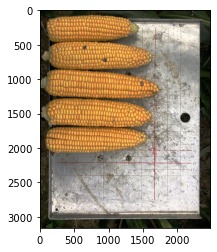

In [4]:
# let's look at an image
fileName = 'testing_IMG_8342.jpg'
image = imread(fileName)
image = exposure.equalize_hist(image) # equalizing the exposure
plt.imshow(image)

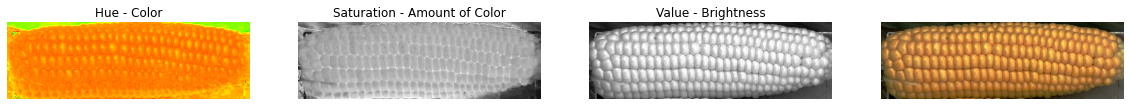

In [27]:
hsv = colors.rgb_to_hsv(top_five[5])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,5))
ax1.imshow(hsv[:,:,0], cmap='hsv')
ax1.set_title('Hue - Color')
ax1.set_axis_off()

ax2.imshow(hsv[:,:,1],cmap='gray',vmin=0, vmax=1)
ax2.set_title('Saturation - Amount of Color')
ax2.set_axis_off()

ax3.imshow(hsv[:,:,2],cmap='gray')
ax3.set_title('Value - Brightness')
ax3.set_axis_off()

ax4.imshow(top_five[5])
ax4.set_axis_off()

In [25]:
from ipywidgets import interactive,fixed #For interactives
def hsv_color_threshold(im, hmin=-0.01,hmax=1.01, smin=-0.01,smax=1.01,vmin=-1,vmax=256):
    # Pull out the red, gree and blue matrixes
    hsv = colors.rgb_to_hsv(im)
    h = hsv[:,:,0];
    s = hsv[:,:,1];
    v = hsv[:,:,2];
    
    # trick because the color space wraps
    if hmin > hmax:
        b_img = (h > hmin) | (h < hmax)
    else:
        b_img = (h > hmin) & (h < hmax);
    
    
    b_img = (b_img & 
         (s > smin) & (s < smax) & 
         (v > vmin) & (v < vmax));
    
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
    ax1.imshow(im)
    ax1.set_axis_off()
    
    ax2.imshow(b_img,cmap='gray', vmin=0, vmax=1)
    ax2.set_title('Value - Brightness')
    ax2.set_axis_off()

    plt.show()
    return b_img*1;

w = interactive(hsv_color_threshold, im=fixed(top_five[5]),
         hmin=(-0.01,1.01,0.01), hmax=(-0.01,1.01,0.01), 
         smin=(-0.01,1.01,0.01), smax=(-0.01,1.01,0.01), 
         vmin=(-1,256), vmax=(-1,256),__manual=True);
w

interactive(children=(FloatSlider(value=-0.01, description='hmin', max=1.01, min=-0.01, step=0.01), FloatSlide…

In [ ]:
image

<ipython-input-12-0207015e6c4e>:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if slices[i] in top_five_slices:


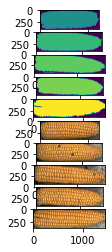

In [14]:
# run the segment_and_crop_loop function and then plot our five objects
top_five = segment_and_crop_loop(image)
fig, ax = plt.subplots(10,1)
ax[0].imshow(top_five[0])
ax[1].imshow(top_five[1])
ax[2].imshow(top_five[2])
ax[3].imshow(top_five[3])
ax[4].imshow(top_five[4])
ax[5].imshow(top_five[5])
ax[6].imshow(top_five[6])
ax[7].imshow(top_five[7])
ax[8].imshow(top_five[8])
ax[9].imshow(top_five[9])

# Measure symmetry index for individual cobs

In [36]:
fileNames = ['IMG_8277.jpg','IMG_8280.jpg','IMG_8333.jpg','IMG_8338.jpg','IMG_8342.jpg','IMG_8343.jpg','IMG_8312.jpg','IMG_8284.jpg','IMG_8349.jpg']

for fileName in fileNames:
    newFileName = "testing_" + fileName
    
    image = imread(newFileName)
    image = exposure.equalize_hist(image)
    
    top_five = segment_and_crop_loop(image)
    #Get horizontal line through middle of photo
    for i in range(5):
        #Clear edges of image from nearby corncobs
        #top_five_eroded = ndimage.binary_erosion(top_five[i],iterations = 5)
        b1 = remove_small_objects(top_five[i],min_size=50000)
        b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)
        #Get mid-line of cob (i.e. number of rows/2)
        midPicture = b2.shape[0]/2

    #What parts of photo are corn?
        indices = np.where(b2 == 1)
    
    #If 1's are not corn, then 
        if indices[0].size == 0:
            indices = np.where(b2 == 0)

    #For each column, what are the tallest and lowest rows with segmented out pixels?
        numCols = b2.shape[1]

    #Subset all rows associated with particular column
        cornRows = indices[0]
        cornCols = indices[1]
        cornColsUq = np.unique(indices[1])

    #indices[np.where(indices):, :]
        midCornPoints = []
        for cornCol in cornColsUq:
            potRows = cornRows[np.where(cornCols == cornCol)]
            minRow = min(potRows)
            maxRow = max(potRows)
            midCorn = (maxRow + minRow)/2
            midCornPoints.append(midCorn)
    
        a = [abs(x - midPicture) for x in midCornPoints] 
        sym = sum(a)/numCols
        print(str(i) + "_" + newFileName)
        print(sym)
        
        plt.imshow(b2)
        plt.plot(np.repeat(midPicture, len(cornColsUq)))
        plt.plot(np.asarray(cornColsUq), np.asarray(midCornPoints))
        plt.savefig(str(i) + "_" + newFileName)
        plt.clf()

C:\Users\miles\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
<ipython-input-12-0207015e6c4e>:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if slices[i] in top_five_slices:
<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


0_testing_IMG_8277.jpg
19.955525606469003


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


1_testing_IMG_8277.jpg
18.14119718309859


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


2_testing_IMG_8277.jpg
19.283450704225352


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


3_testing_IMG_8277.jpg
19.311831789023522


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


4_testing_IMG_8277.jpg
27.031354236157437


C:\Users\miles\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
<ipython-input-12-0207015e6c4e>:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if slices[i] in top_five_slices:
<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


0_testing_IMG_8280.jpg
29.19334456613311


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


1_testing_IMG_8280.jpg
25.23174603174603


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


2_testing_IMG_8280.jpg
42.907762938230384


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


3_testing_IMG_8280.jpg
44.17339449541284


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


4_testing_IMG_8280.jpg
34.087751371115175


C:\Users\miles\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
<ipython-input-12-0207015e6c4e>:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if slices[i] in top_five_slices:
<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


0_testing_IMG_8333.jpg
18.992120814182535


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


1_testing_IMG_8333.jpg
20.626463700234194


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


2_testing_IMG_8333.jpg
17.939607843137257


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


3_testing_IMG_8333.jpg
23.168374816983896


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


4_testing_IMG_8333.jpg
15.915557404326123


C:\Users\miles\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
<ipython-input-12-0207015e6c4e>:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if slices[i] in top_five_slices:
<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


0_testing_IMG_8338.jpg
39.100152905198776


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


1_testing_IMG_8338.jpg
8.360877985797288


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


2_testing_IMG_8338.jpg
8.342563291139241


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


3_testing_IMG_8338.jpg
30.6652739090065


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


4_testing_IMG_8338.jpg
12.54602510460251


C:\Users\miles\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
<ipython-input-12-0207015e6c4e>:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if slices[i] in top_five_slices:
<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


0_testing_IMG_8342.jpg
11.002843216896832


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


1_testing_IMG_8342.jpg
9.414768806073154


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


2_testing_IMG_8342.jpg
27.931150550795593


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


3_testing_IMG_8342.jpg
19.273324572930356


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


4_testing_IMG_8342.jpg
10.151724137931035


C:\Users\miles\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
<ipython-input-12-0207015e6c4e>:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if slices[i] in top_five_slices:
<ipython-input-36-f0668ec24f0f>:14: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  b1 = remove_small_objects(top_five[i],min_size=50000)
<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


0_testing_IMG_8343.jpg
20.464673913043477


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


1_testing_IMG_8343.jpg
19.901883830455258


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


2_testing_IMG_8343.jpg
8.26597510373444


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


3_testing_IMG_8343.jpg
16.118819188191882


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


4_testing_IMG_8343.jpg
10.407672849915683


C:\Users\miles\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
<ipython-input-12-0207015e6c4e>:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if slices[i] in top_five_slices:
<ipython-input-36-f0668ec24f0f>:14: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  b1 = remove_small_objects(top_five[i],min_size=50000)
<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


0_testing_IMG_8312.jpg
14.272147147147146


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


1_testing_IMG_8312.jpg
20.700848111025444


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


2_testing_IMG_8312.jpg
15.194921316165951


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


3_testing_IMG_8312.jpg
32.23184568835099


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


4_testing_IMG_8312.jpg
36.96236933797909


C:\Users\miles\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
<ipython-input-12-0207015e6c4e>:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if slices[i] in top_five_slices:
<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


0_testing_IMG_8284.jpg
12.707259953161593


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


1_testing_IMG_8284.jpg
19.274963820549928


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


2_testing_IMG_8284.jpg
10.708484408992023


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


3_testing_IMG_8284.jpg
9.23221586263287


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


4_testing_IMG_8284.jpg
15.707116104868915


C:\Users\miles\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
<ipython-input-12-0207015e6c4e>:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if slices[i] in top_five_slices:
<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


0_testing_IMG_8349.jpg
15.88162951575711


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


1_testing_IMG_8349.jpg
12.344286781179985


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


2_testing_IMG_8349.jpg
11.991830065359476


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


3_testing_IMG_8349.jpg
11.165701881331405


<ipython-input-36-f0668ec24f0f>:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  b2 = skimage.morphology.remove_small_holes(b1,area_threshold=10000)


4_testing_IMG_8349.jpg
11.888167938931298


<Figure size 432x288 with 0 Axes>

# Measure straightness of kernel rows 

In [28]:
fileNames = ['IMG_8277.jpg','IMG_8280.jpg','IMG_8333.jpg','IMG_8338.jpg','IMG_8342.jpg','IMG_8343.jpg','IMG_8312.jpg','IMG_8284.jpg','IMG_8349.jpg']

for fileName in fileNames:
    newFileName = "testing_" + fileName
    
    image = imread(newFileName)
    image = exposure.equalize_hist(image)
    
    #Crop out individual ears
    top_five = segment_and_crop_loop(image)
    
    #Convert binary image back into non-binary
    for i in range(5,10):
        #Clear edges of image from nearby corncobs
        cobImg = top_five[i]
        
        #Define thresholds for isolating tray in photos
        hmin = 0.09
        hmax = 1.01
        smin = 0.60
        smax = 1.01
        vmin = -1
        vmax = 256

        #convert from rgb to hsv color space, pull out matrices
        hsv = colors.rgb_to_hsv(cobImg)
        h = hsv[:,:,0]; #hue matrix
        s = hsv[:,:,1]; #saturation matrix
        v = hsv[:,:,2]; #value matrix (i.e. brightness)
    
        #Convert to binary image based on thresholds
        # trick because the color space wraps
        if hmin > hmax:
            b_img = (h > hmin) | (h < hmax)
        else:
            b_img = (h > hmin) & (h < hmax);
            b_img = (b_img & 
                (s > smin) & (s < smax) & 
                (v > vmin) & (v < vmax));
    
        #Calculate entropy (i.e. disorder in pixel/kernel arangement)
        entropy = skimage.measure.shannon_entropy(b_img)
        imsave("binary_" + str(i) + "_" + newFileName, b_img * 255)
        print("binary_" + str(i) + "_" + newFileName)
        print(entropy)

<ipython-input-12-0207015e6c4e>:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if slices[i] in top_five_slices:
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8277.jpg
0.9750623245767689
IMG_8277.jpg
0.9867738045969116


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8277.jpg
0.9943883839907812
IMG_8277.jpg
0.9799962778627715


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8277.jpg
0.9627095033482059


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8280.jpg
0.9679978849774453
IMG_8280.jpg
0.9924214047432948


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8280.jpg
0.9850685530731956
IMG_8280.jpg
0.9921341248754995


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8280.jpg
0.9466447397708031


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8333.jpg
0.997689228532454
IMG_8333.jpg
0.9887962242433832


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8333.jpg
0.9420878391417088


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8333.jpg
0.988073864906906
IMG_8333.jpg
0.9519034371621221


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8338.jpg
0.999928690272161
IMG_8338.jpg
0.9708932992951338


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8338.jpg
0.9972605405193087
IMG_8338.jpg
0.979844140677836


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8338.jpg
0.9769691190475105


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8342.jpg
0.8928985262503714
IMG_8342.jpg
0.9386338214317143


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8342.jpg
0.8560316194559883
IMG_8342.jpg
0.9134213851875506


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8342.jpg
0.8842943567739031


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8343.jpg
0.8848985195057305
IMG_8343.jpg
0.8071692966487855


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8343.jpg
0.7551352981177353
IMG_8343.jpg
0.7941751258523077


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8343.jpg
0.874361707834629


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8312.jpg
0.996543613879592
IMG_8312.jpg
0.9894601542396335


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8312.jpg
0.9982049015197672
IMG_8312.jpg
0.9931648895105999


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8312.jpg
0.9999369357491962


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8284.jpg
0.7691835368183427
IMG_8284.jpg
0.8185950135639719


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8284.jpg
0.8099070116778295
IMG_8284.jpg
0.8369429397075349


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8284.jpg
0.9018236525262856


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8349.jpg
0.9965872838722901
IMG_8349.jpg
0.9959014508004058


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8349.jpg
0.9809244932730179
IMG_8349.jpg
0.9991167493316601


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


IMG_8349.jpg
0.9988934041357023
